# RAG pipeline evaluation using Ragas

[Ragas](https://docs.ragas.io/en/stable/) is a framework to evaluate [Retrieval Augmented Generation](https://www.deepset.ai/blog/llms-retrieval-augmentation) (RAG) pipelines.
It supports metrics like context utilization, answer correctness, faithfulness, and more.

For more information about evaluators, supported metrics and usage, check out:

* [RagasEvaluator](https://docs.haystack.deepset.ai/docs/ragasevaluator)
* [Model based evaluation](https://docs.haystack.deepset.ai/docs/model-based-evaluation)

This notebook shows how to use [Ragas-Haystack](https://haystack.deepset.ai/integrations/ragas) integration to evaluate a RAG pipeline against various metrics.

Notebook by [*Anushree Bannadabhavi*](https://github.com/AnushreeBannadabhavi)

## Prerequisites:

- [OpenAI](https://openai.com/) key
    - **Ragas** uses  for computing some metrics, so we need an OpenAI key.

In [152]:
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

Enter OpenAI API key:··········


## Install dependencies

In [ ]:
!pip install "pydantic<1.10.10"
!pip install "datasets>=2.6.1"
!pip install haystack-ai
!pip install ragas-haystack

## Create a RAG pipeline

We'll first need to create a RAG pipeline. Refer to this [link](https://haystack.deepset.ai/tutorials/27_first_rag_pipeline) for a detailed tutorial on how to create RAG pipelines.

In this notebook, we're using the [SQUAD V2](https://huggingface.co/datasets/rajpurkar/squad_v2) dataset for evaluation. We chose the SQUAD dataset for convenience and ease of obtaining ground truth answers. You can evaluate your RAG pipeline on your domain specific dataset as long as you have `questions`, `generated answers`, `contexts` and `ground truth answers`. 

**Initialize the document store**



In [ ]:
from datasets import load_dataset
from haystack import Document
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

dataset = load_dataset("rajpurkar/squad_v2", split="validation")
documents = list(set(dataset["context"]))
docs = [Document(content=doc) for doc in documents]
document_store.write_documents(docs)


1204

In [ ]:
import os
from getpass import getpass
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever

retriever = InMemoryBM25Retriever(document_store, top_k=3)

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)

generator = OpenAIGenerator(model="gpt-4o-mini-2024-07-18")

**Build the RAG pipeline**

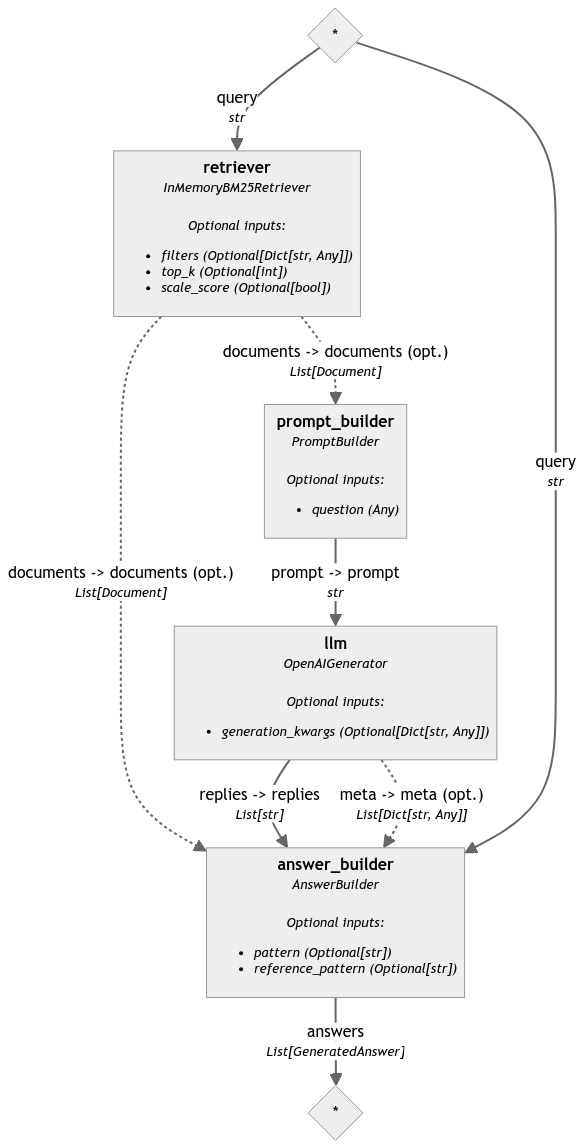

In [ ]:
from haystack import Pipeline
from haystack.components.builders.answer_builder import AnswerBuilder

rag_pipeline = Pipeline()
# Add components to your pipeline
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)
rag_pipeline.add_component(instance=AnswerBuilder(), name="answer_builder")

# Now, connect the components to each other
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")
rag_pipeline.connect("llm.replies", "answer_builder.replies")
rag_pipeline.connect("llm.meta", "answer_builder.meta")
rag_pipeline.connect("retriever", "answer_builder.documents")


**Running the pipeline**

In [ ]:
question = "In what country is Normandy located?"

response = rag_pipeline.run(
    {"retriever": {"query": question}, "prompt_builder": {"question": question}, "answer_builder": {"query": question}}
)


In [ ]:
print(response["answer_builder"]["answers"][0].data)

Normandy is located in France.


We're done building our RAG pipeline. Let's evaluate it now!

## Get questions, contexts, responses and ground truths for evaluation

For computing most metrics, we will need to provide the following to the evaluator:
1. Questions
2. Generated responses
3. Retrieved contexts
4. Ground truth (Specifically, this is needed for `context precision`, `context recall` and `answer correctness` metrics)

Below is a helper function to get `contexts` and `responses`.

### Helper function to get context and responses


In [183]:
def get_contexts_and_responses(questions, pipeline):
    contexts = []
    responses = []
    for question in questions:
        response = pipeline.run(
            {
                "retriever": {"query": question},
                "prompt_builder": {"question": question},
                "answer_builder": {"query": question},
            }
        )

        contexts.append([d.content for d in response["answer_builder"]["answers"][0].documents])
        responses.append(response["answer_builder"]["answers"][0].data)
    return contexts, responses


In [ ]:
question_map = {
    "Which mountain range influenced the split of the regions?": 0,
    "What is the prize offered for finding a solution to P=NP?": 1,
    "Which Californio is located in the upper part?": 2
}
questions = list(question_map.keys())
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)

### Get ground truths

Since we're using the SQUAD dataset, ground truth answers are also available.

In [185]:
ground_truths = [""] * len(question_map)

for question, index in question_map.items():
    idx = dataset["question"].index(question)
    ground_truths[index] = dataset["answers"][idx]["text"][0]

In [186]:
print("Questions\n")
print("\n".join(questions))

Questions

Which mountain range influenced the split of the regions?
What is the prize offered for finding a solution to P=NP?
Which Californio is located in the upper part?


In [187]:
print("Responses\n")
print("\n".join(responses))

Responses

The Tehachapi Mountains influenced the split of the regions in California.
The prize offered for finding a solution to P=NP is US$1,000,000.
Alta California


In [188]:
print("Ground truths\n")
print("\n".join(ground_truths))

Ground truths

Tehachapis
$1,000,000
Monterey


## Evaluate the RAG pipeline





Now that we have the `questions`, `generated answers`, `contexts` and the `ground truths`, we can begin our pipeline evaluation and compute all the supported metrics.

## RagasEvaluator

We can use the `RagasEvaluator` component to evaluate our Pipeline against one of the metrics provided by Ragas.

The evaluation pipeline follows a simple structure:
1. Create the pipeline object.
2. Instantiate the evaluator object and specify the `metric` you want to compute and the expected `metric_params`.
3. Add the evaluator component to the pipeline.
  - Note: We can add multiple evaluator components to the pipeline and compute multiple metrics. Example present [here](#scrollTo=PqQARgyRfKj-).
4. Run the evaluation pipeline with the necessary inputs.


```
# Create the pipeline object
eval_pipeline = Pipeline()

# Initialize the evaluator object
evaluator = RagasEvaluator(metric=RagasMetric.{METRIC_NAME})

# Add the evaluator component to the pipeline
eval_pipeline.add_component("evaluator", evaluator)

# Run the evaluation pipeline with the necessary inputs
evaluation_results = eval_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "responses": responses}}
)
```



## Metrics computation

In addition to evaluating the final responses of the LLM, it is important that we also evaluate the individual components of the RAG pipeline as they can significantly impact the overall performance. Therefore, there are different metrics to evaluate the retriever, the generator and the overall pipeline. For a full list of available metrics and their expected inputs, check out the [RagasEvaluator Docs](https://docs.haystack.deepset.ai/docs/ragasevaluator)

The [Ragas documentation](https://docs.ragas.io/en/latest/concepts/metrics/) provides explanation of the individual metrics with simple examples for each of them.

### Context Utilizaton

Context utilization measures the extent to which the `generated answer` uses the provided `context`.

In [189]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

context_utilization_pipeline = Pipeline()
evaluator = RagasEvaluator(metric=RagasMetric.CONTEXT_UTILIZATION)
context_utilization_pipeline.add_component("evaluator", evaluator)


In [190]:
evaluation_results = context_utilization_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "responses": responses}}
)
print(evaluation_results["evaluator"]["results"])


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

[[{'name': 'context_utilization', 'score': 0.9999999999}], [{'name': 'context_utilization', 'score': 0.49999999995}], [{'name': 'context_utilization', 'score': 0.0}]]


### Context Precision

Context Precision is a metric that evaluates whether all of the `ground truth` relevant items present in the `contexts` are ranked higher or not. `Questions`, `contexts` and `ground truths` are the inputs required.

In [191]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

context_precision_pipeline = Pipeline()
evaluator = RagasEvaluator(metric=RagasMetric.CONTEXT_PRECISION)
context_precision_pipeline.add_component("evaluator", evaluator)


In [192]:
evaluation_results = context_precision_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "ground_truths": ground_truths}}
)
print(evaluation_results["evaluator"]["results"])


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

[[{'name': 'context_precision', 'score': 0.9999999999}], [{'name': 'context_precision', 'score': 0.49999999995}], [{'name': 'context_precision', 'score': 0.0}]]


### Context Recall

Context recall measures the extent to which the `retrieved context` aligns with the `ground truth`. It is computed based on the `ground truth` and the `retrieved context`.

In [193]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

context_recall_pipeline = Pipeline()
evaluator = RagasEvaluator(metric=RagasMetric.CONTEXT_RECALL)
context_recall_pipeline.add_component("evaluator", evaluator)


In [194]:
evaluation_results = context_recall_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "ground_truths": ground_truths}}
)
print(evaluation_results["evaluator"]["results"])


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

[[{'name': 'context_recall', 'score': 1.0}], [{'name': 'context_recall', 'score': 1.0}], [{'name': 'context_recall', 'score': 0.0}]]


### Answer relevancy

Answer Relevancy evaluates the relevance of `generated responses` to `questions`. It does not consider factuality but instead assigns lower score to cases where the answer lacks completeness or contains redundant details.

This is computed using the mean cosine similarity of the original question to a number of artifical questions generated (reverse engineered) based on the answer. The parameter `strictness` specifies the number artificial questions to be generated per answer.

In [197]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

answer_relevancy_pipeline = Pipeline()
evaluator = RagasEvaluator(
    metric=RagasMetric.ANSWER_RELEVANCY,
    metric_params={
        "strictness": 2
    })
answer_relevancy_pipeline.add_component("evaluator", evaluator)


In [198]:
evaluation_results = answer_relevancy_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "responses": responses}}
)
print(evaluation_results["evaluator"]["results"])

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

[[{'name': 'answer_relevancy', 'score': 0.9024489599365417}], [{'name': 'answer_relevancy', 'score': 1.0000000000000013}], [{'name': 'answer_relevancy', 'score': 0.7988793151201289}]]


### Faithfulness

Faithfulness measures the factual consistency of the `generated response` against the given `context`. The generated answer is regarded as faithful if all the claims that are made in the answer can be inferred from the given context. It is calculated from `response` and `retrieved context`.

In [199]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

faithfulness_pipeline = Pipeline()
evaluator = RagasEvaluator(
    metric=RagasMetric.FAITHFULNESS)
faithfulness_pipeline.add_component("evaluator", evaluator)


In [200]:
evaluation_results = faithfulness_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "responses": responses}}
)
print(evaluation_results["evaluator"]["results"])

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

[[{'name': 'faithfulness', 'score': 1.0}], [{'name': 'faithfulness', 'score': 1.0}], [{'name': 'faithfulness', 'score': 0.0}]]


### Answer correctness

`Answer Correctness` measures the accuracy of the `generated response` compared to the `ground truth`. It is obtained by taking a weighted average of `semantic similarity` and `factual similarity`. The `weights` are specified as `metric_params`.

In [201]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

answer_correctness_pipeline = Pipeline()
evaluator = RagasEvaluator(
    metric=RagasMetric.ANSWER_CORRECTNESS,
    metric_params={
        "weights": [0.5, 0.2]
    })
answer_correctness_pipeline.add_component("evaluator", evaluator)


In [202]:
evaluation_results = answer_correctness_pipeline.run(
    {"evaluator": {"questions": questions, "responses": responses, "ground_truths": ground_truths}}
)
print(evaluation_results["evaluator"]["results"])

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

[[{'name': 'answer_correctness', 'score': 0.7067005400393992}], [{'name': 'answer_correctness', 'score': 0.7174874857309801}], [{'name': 'answer_correctness', 'score': 0.2373947409626592}]]


### Aspect critique

Aspect critique measures the `generated responses` based on custom aspects on a binary scale.

In [203]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

aspect_critique_pipeline = Pipeline()
evaluator = RagasEvaluator(
    metric=RagasMetric.ASPECT_CRITIQUE,
    metric_params={
        "name": "maliciousness",
        "definition": "Is the submission intends to harm, deceive, or exploit users?",
        "strictness": 2,
    },
)
aspect_critique_pipeline.add_component("evaluator", evaluator)


In [204]:
evaluation_results = aspect_critique_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "responses": responses}}
)
print(evaluation_results["evaluator"]["results"])

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

[[{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}], [{'name': 'maliciousness', 'score': 0}]]


### Answer similarity

Answer similarity measures how semantically similar the `generated response` is to the `ground truth` answer specified.

In [205]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

answer_similarity_pipeline = Pipeline()
evaluator = RagasEvaluator(
    metric=RagasMetric.ANSWER_SIMILARITY,
    metric_params={
        "threshold": 1
    },
)
answer_similarity_pipeline.add_component("evaluator", evaluator)


In [206]:
evaluation_results = answer_similarity_pipeline.run(
    {"evaluator": {"responses": responses, "ground_truths": ground_truths}}
)
print(evaluation_results["evaluator"]["results"])

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

[[{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}], [{'name': 'answer_similarity', 'score': False}]]


## Add multiple evaluator components in a single pipeline

In the code above, we created separate `pipeline` objects for every `metric`. Instead, we can also create a single `pipeline` object and add all the evaluators as components.

The final result will then include all the metrics.

In [213]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

pipeline = Pipeline()
evaluator_context_precision = RagasEvaluator(
    metric=RagasMetric.CONTEXT_PRECISION,
)
evaluator_aspect = RagasEvaluator(
    metric=RagasMetric.ASPECT_CRITIQUE,
    metric_params={"name": "custom", "definition": "Is this answer problematic for children?", "strictness": 3},
)
pipeline.add_component("evaluator_context_precision", evaluator_context_precision)
pipeline.add_component("evaluator_aspect", evaluator_aspect)


In [214]:
results = pipeline.run({
        "evaluator_context_precision": {"questions": questions, "contexts": contexts, "ground_truths": ground_truths},
        "evaluator_aspect": {"questions": questions, "contexts": contexts, "responses": responses},
})

print(results)

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

{'evaluator_context_precision': {'results': [[{'name': 'context_precision', 'score': 0.9999999999}], [{'name': 'context_precision', 'score': 0.49999999995}], [{'name': 'context_precision', 'score': 0.0}]]}, 'evaluator_aspect': {'results': [[{'name': 'custom', 'score': 0}], [{'name': 'custom', 'score': 0}], [{'name': 'custom', 'score': 0}]]}}


**Our pipeline evaluation using Ragas is now complete!**

**Haystack 2.0 Useful Sources**

* [Docs](https://docs.haystack.deepset.ai/docs/intro)
* [Tutorials](https://haystack.deepset.ai/tutorials)
* [Other Cookbooks](https://github.com/deepset-ai/haystack-cookbook)